<a href="https://colab.research.google.com/github/cjelgin/bird_classifier/blob/master/Bird_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary packages

In [0]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib


### Download bird dataset from Kaggle





In [0]:
#Install the kaggle package utility using pip
!pip install -q kaggle

In [0]:
#Download the bird image dataset from kaggle using the kaggle api
def download_bird_data():
  from google.colab import files
  files.upload()

  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 /root/.kaggle/kaggle.json
  ! kaggle datasets list
  data_path = "/content/drive/My Drive/Dev/Datasets/Birds"

  ! kaggle datasets download -d gpiosenka/100-bird-species -p '/content/drive/My Drive/Dev/Datasets/Birds'
  ! unzip '/content/drive/My Drive/Dev/Datasets/Birds/100-bird-species.zip' -d '/content/drive/My Drive/Dev/Datasets/Birds'

### Load bird dataset

The images are first loaded as a list of image files under the "consolidated" parent directory. The images are then loaded as a tf.data.Dataset using the list_files() method. The list_files() function is used to collect image files from each directory. Shuffle=True ensures that file names will be shuffled randomly(using seed).

In [0]:
# All bird images are located in the following directory structure /consolidates/SPECIES_NAME/xxx.jpg
data_dir='/content/drive/My Drive/Dev/Datasets/Birds/consolidated'
data_dir=pathlib.Path(data_dir)
bird_count=len(list(data_dir.glob('*/*.jpg'))) #Total number of bird images

birds_ds=tf.data.Dataset.list_files(str('/content/drive/My Drive/Dev/Datasets/Birds/consolidated/*/*'),shuffle=True, seed=33)

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]) #Class labels

25309

All image files in the 'consolidated' directory are shuffled and then split. The first 1,000 images are assigned to the test set, the next 10,000 to the validation set, and the remaining images to the training set.

In [0]:
test_ds = birds_ds.take(1000)
val_ds = birds_ds.skip(1000).take(10000)
train_ds = birds_ds.skip(11000)

Here, a sample of the first 5 files from each set demonstrates that the imagaes are shuffled.

In [0]:
print("TRAINING SAMPLE")
for f in train_ds.take(5):
  print(f.numpy())
print("VALIDATION SAMPLE")
for f in val_ds.take(5):
  print(f.numpy())
print("TEST SAMPLE")
for f in test_ds.take(5):
  print(f.numpy())

TRAINING SAMPLE
b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/BLUE GROUSE/193.jpg'
b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/RUFUOS MOTMOT/151.jpg'
b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/MOURNING DOVE/039.jpg'
b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/CROW/031.jpg'
b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/AMERICAN REDSTART/076.jpg'
VALIDATION SAMPLE
b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/LONG-EARED OWL/090.jpg'
b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/COMMON GRACKLE/044.jpg'
b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/ARARIPE MANAKIN/065.jpg'
b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/CASPIAN TERN/150.jpg'
b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/BELTED KINGFISHER/081.jpg'
TEST SAMPLE
b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/STORK BILLED KINGFISHER/067.jpg'
b'/content/drive/My Drive/Dev/Datasets/Birds/consolid

### Sample split diagnostics

In [0]:
#save list of images in test set for future use
ts=np.array(list(test_ds.as_numpy_iterator()))
np.save('/content/drive/My Drive/Dev/Datasets/Birds/Test_Set.npy', ts)

In [0]:
def get_bird_counts(set):
  counts=[0]*175
  for bird in list(set.as_numpy_iterator()) :
    parts = tf.strings.split(bird, os.path.sep)
    # The second to last is the class-directory
    species = parts[-2] 
    lab_index=list(CLASS_NAMES).index(species)
    counts[lab_index] +=1
  return counts 


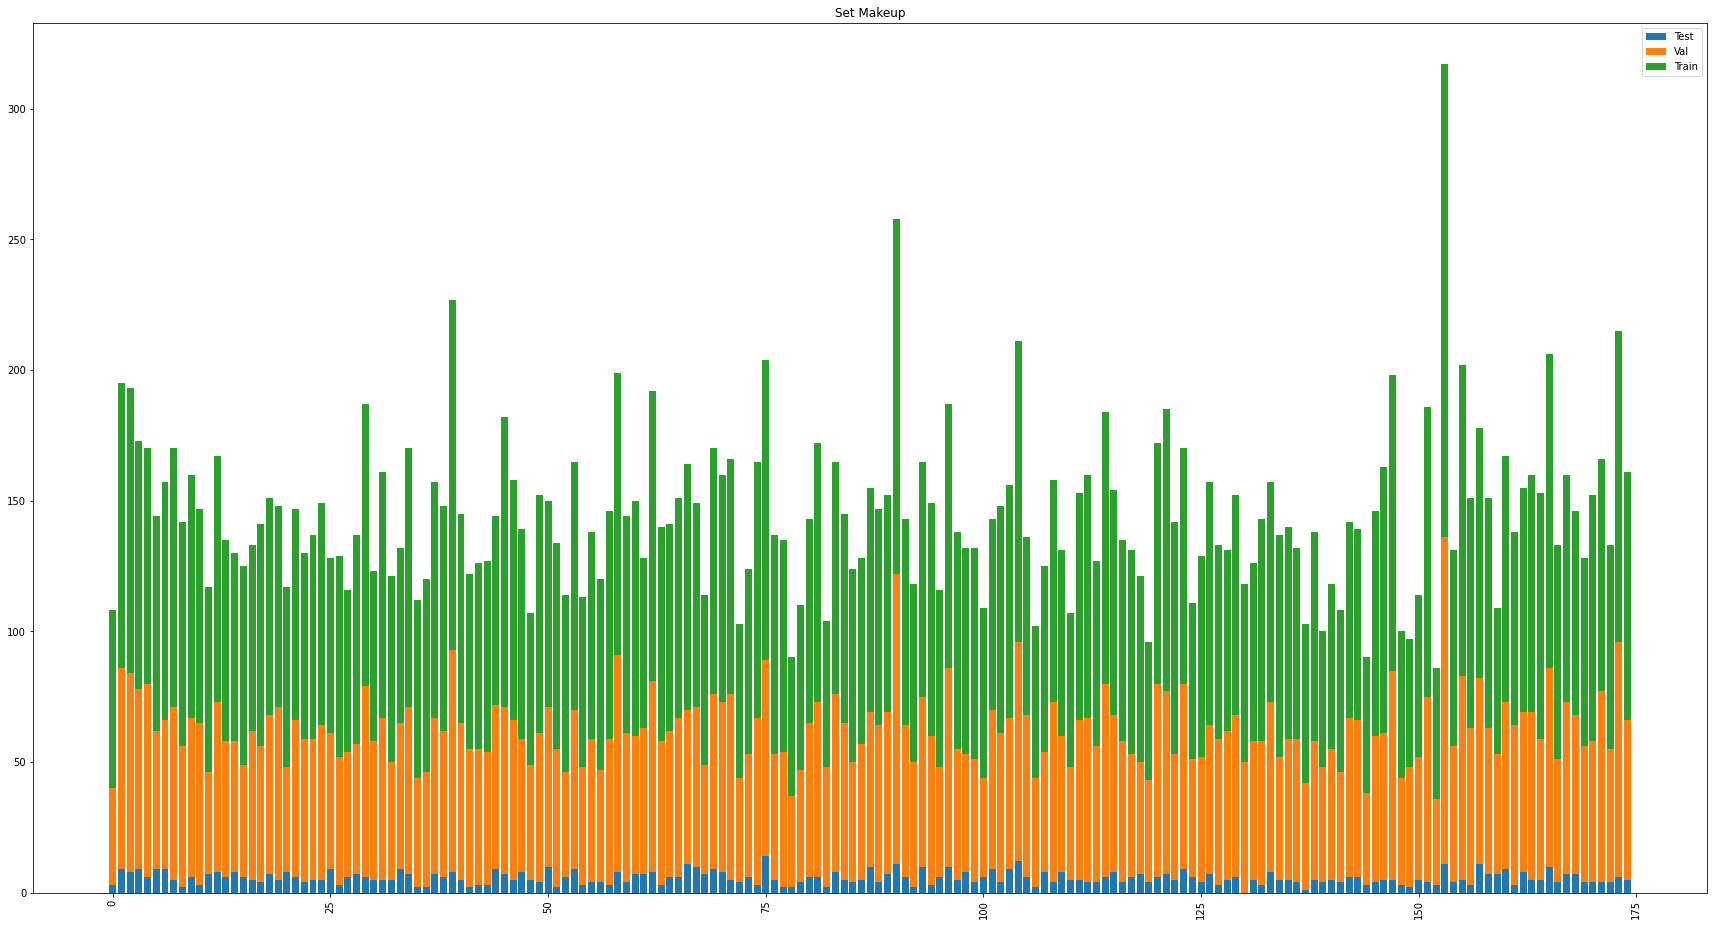

In [0]:
train_counts = get_bird_counts(train_ds)
val_counts = get_bird_counts(val_ds)
test_counts = get_bird_counts(test_ds)

fig, ax = plt.subplots(figsize=(30,16))

species_num=list(range(175))
train_list_vals=[x + y for x, y in zip(test_counts, val_counts)]
ax.bar(species_num, test_counts, label='Test')
ax.bar(species_num, val_counts, bottom=test_counts , label="Val")
ax.bar(species_num, train_counts, bottom=train_list_vals , label="Train" )

ax.set_label('Count')
ax.set_title('Set Makeup')
ax.legend()
plt.xticks(rotation=90)
plt.show()

### Data preparation and augmentation

In this section, we will assign labels to all images in Train/Val/Test sets and turn our dataset of filepaths into a dataset of decoded jpeg images.

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return float(parts[-2] == CLASS_NAMES)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  #img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  #run the image through Xception's preprocess_input function
  #img = tf.keras.applications.xception.preprocess_input(img)
  return img, label


In [0]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

#Create image and label pairs
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_birds_raw = train_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_birds_raw = val_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_birds_raw = test_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)



 Preview of first 3 images in each set

TRAINING SET


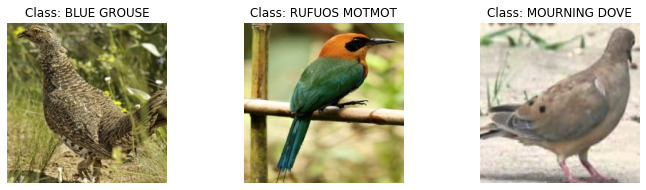

VALIDATION SET


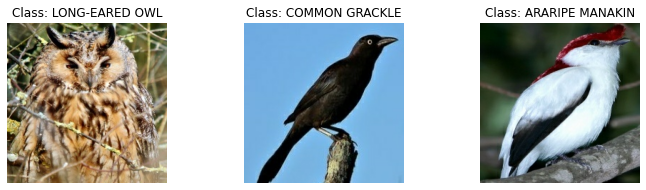

TEST SET


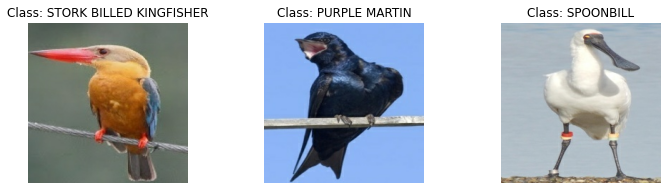

In [0]:
print('TRAINING SET')
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_birds_raw.take(3):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image /255 )
    num = tf.argmax(label, axis=0)
    plt.title("Class: {}".format(list(CLASS_NAMES)[num]))
    plt.axis("off")

plt.show()
print('VALIDATION SET')
plt.figure(figsize=(12, 10))
index = 0
for image, label in val_birds_raw.take(3):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image /255 )
    num = tf.argmax(label, axis=0)
    plt.title("Class: {}".format(list(CLASS_NAMES)[num]))
    plt.axis("off")

plt.show()
print('TEST SET')
plt.figure(figsize=(12, 10))
index = 0
for image, label in test_birds_raw.take(3):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image /255 )
    num = tf.argmax(label, axis=0)
    plt.title("Class: {}".format(list(CLASS_NAMES)[num]))
    plt.axis("off")

plt.show()

In order to make the image collection more realistic, a simple augmentation is performed on each set.

Training images are shuffled, and the sequence is repeated. Training images are subjected to a randomized crop, while validation and test images are given a central crop. All images are run through the pre-processing function from the Xception model.

In [0]:
from functools import partial


def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [IMG_WIDTH, IMG_HEIGHT])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label



In [0]:
BATCH_SIZE=32
num_species=len(CLASS_NAMES)

train_birds_raw = train_birds_raw.shuffle(buffer_size=1000, seed=33).repeat()
train_birds=train_birds_raw.map(partial(preprocess, randomize=True)).batch(BATCH_SIZE).prefetch(1)
val_birds=val_birds_raw.map(preprocess).batch(BATCH_SIZE).prefetch(1)
test_birds=test_birds_raw.map(preprocess).batch(BATCH_SIZE).prefetch(1)


Below is a sample of the training images after the random cropping.





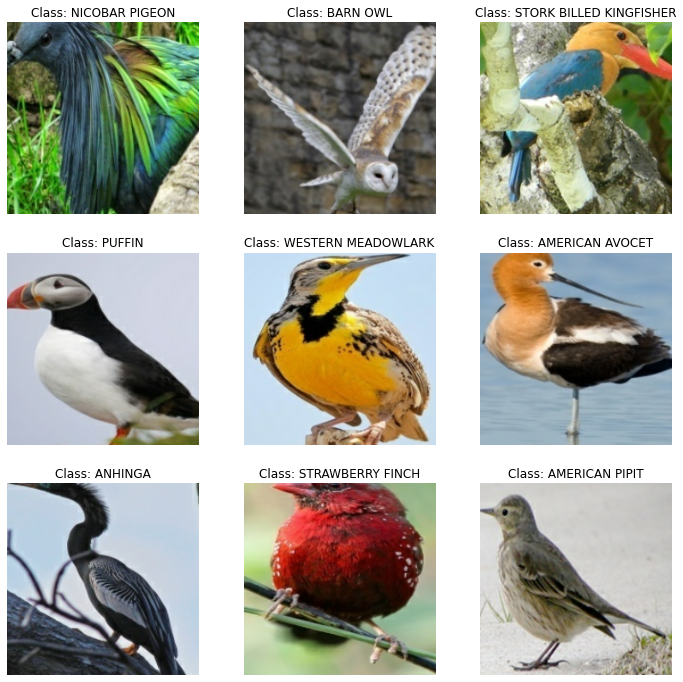

In [0]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_birds.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        num = tf.argmax(y_batch[index], axis=0)
        plt.title("Class: {}".format(list(CLASS_NAMES)[num]))
        plt.axis("off")

plt.show()


### Model building and training

For the purpose of this classification model, we will be starting with pretrained layers from the Xception model.

In [0]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(num_species, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 0s 0us/step


In [0]:
for layer in base_model.layers:
    layer.trainable = False

In [0]:
optimizer = tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [0]:
checkpoint_path = "/content/drive/My Drive/Dev/Models/Birds/birds-175v6.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


csv_logger = tf.keras.callbacks.CSVLogger(filename="/content/drive/My Drive/Dev/Models/Birds/model_history_log_v6.csv", append=True)


After keeping the weights ofthe pre-trained layers constant, the model is initially trained for 5 epochs, reaching approx. 92% validation accuracy.

In [0]:

tsteps=14309
vsteps=1000
history = model.fit(train_birds, 
                    epochs=5, 
                    steps_per_epoch=int(tsteps/BATCH_SIZE),
                    validation_data=val_birds, 
                    validation_steps=int(vsteps/BATCH_SIZE),
                    verbose=1, 
                    callbacks=[cp_callback,csv_logger])

Epoch 1/5
447/447 [==============================] - ETA: 0s - loss: 1.2449 - accuracy: 0.7283
Epoch 00001: saving model to /content/drive/My Drive/Dev/Models/Birds/birds-175v6.ckpt
447/447 [==============================] - 548s 1s/step - loss: 1.2449 - accuracy: 0.7283 - val_loss: 0.3708 - val_accuracy: 0.8891
Epoch 2/5
447/447 [==============================] - ETA: 0s - loss: 0.3881 - accuracy: 0.8913
Epoch 00002: saving model to /content/drive/My Drive/Dev/Models/Birds/birds-175v6.ckpt
447/447 [==============================] - 430s 963ms/step - loss: 0.3881 - accuracy: 0.8913 - val_loss: 0.3094 - val_accuracy: 0.9133
Epoch 3/5
447/447 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.9103
Epoch 00003: saving model to /content/drive/My Drive/Dev/Models/Birds/birds-175v6.ckpt
447/447 [==============================] - 271s 606ms/step - loss: 0.3202 - accuracy: 0.9103 - val_loss: 0.2575 - val_accuracy: 0.9244
Epoch 4/5
447/447 [==============================] -

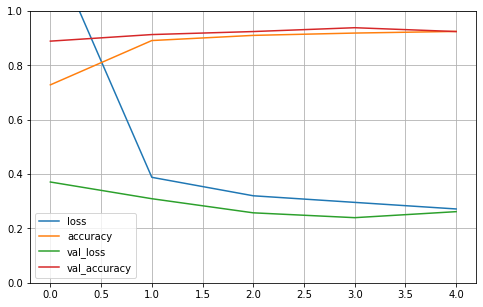

In [0]:
import pandas as pd


pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

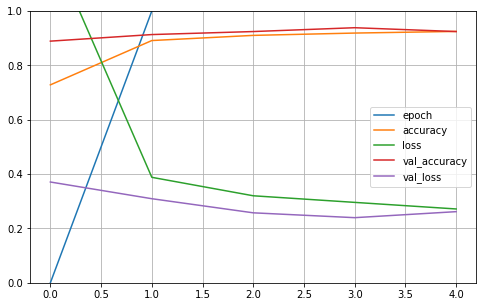

In [0]:
import pandas as pd

h1=pd.read_csv('/content/drive/My Drive/Dev/Models/Birds/model_history_log_v6.csv')
pd.DataFrame(h1).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


After releasing the initial pre-trained layers, the model is trained again for an additional 5 epochs, reaching approx. 98% validation accuracy.

In [0]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

checkpoint_path = "/content/drive/My Drive/Dev/Models/Birds/birds-175v7.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#history_path = "/content/drive/My Drive/Dev/Models/Birds/model_history_log_v5.csv"
#history_dir = os.path.dirname(history_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


csv_logger = tf.keras.callbacks.CSVLogger(filename="/content/drive/My Drive/Dev/Models/Birds/model_history_log_v7.csv", append=True)



In [0]:

tsteps=14309
vsteps=1000
history = model.fit(train_birds, 
                    epochs=5, 
                    steps_per_epoch=int(tsteps/BATCH_SIZE),
                    validation_data=val_birds, 
                    validation_steps=int(vsteps/BATCH_SIZE),
                    verbose=1, 
                    callbacks=[cp_callback,csv_logger])

Epoch 1/5
447/447 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.9200
Epoch 00001: saving model to /content/drive/My Drive/Dev/Models/Birds/birds-175v7.ckpt
447/447 [==============================] - 1528s 3s/step - loss: 0.2987 - accuracy: 0.9200 - val_loss: 0.1409 - val_accuracy: 0.9577
Epoch 2/5
447/447 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9597
Epoch 00002: saving model to /content/drive/My Drive/Dev/Models/Birds/birds-175v7.ckpt
447/447 [==============================] - 1512s 3s/step - loss: 0.1571 - accuracy: 0.9597 - val_loss: 0.1172 - val_accuracy: 0.9688
Epoch 3/5
447/447 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.9674
Epoch 00003: saving model to /content/drive/My Drive/Dev/Models/Birds/birds-175v7.ckpt
447/447 [==============================] - 1463s 3s/step - loss: 0.1365 - accuracy: 0.9674 - val_loss: 0.0850 - val_accuracy: 0.9778
Epoch 4/5
447/447 [==============================] - ET

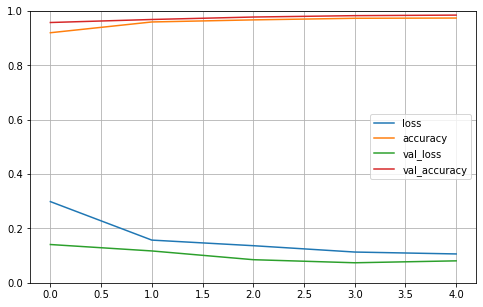

In [0]:
import pandas as pd


pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

### Make predictions using the test set

In [0]:
#get_top_n is a function to decode the top n predicted bird species
def get_top_n(predictions,n,class_labels):
  num_preds = predictions.shape[0]
  pred_list = []
  for pred in range(num_preds):
    topn_dict={}
    topn_indices = np.argpartition(predictions[pred], -n)[-n:]
    for each in range(topn_indices.shape[0]):
      bird_name = class_labels[topn_indices[each]]
      y_prob = predictions[pred][topn_indices[each]]
      topn_dict.update({bird_name : y_prob})
    topn_dict_ordered = sorted(topn_dict.items(), key=lambda item: item[1] , reverse=True)
    pred_list.append(topn_dict_ordered)
  return pred_list

In [0]:
pred_birds=model.predict(test_birds)

preds = get_top_n(pred_birds[0],5,CLASS_NAMES)
preds

{'COUCHS KINGBIRD': 0.094554126,
 'GRAY CATBIRD': 0.02004843,
 'NORTHERN MOCKINGBIRD': 0.8414572,
 'SPLENDID WREN': 0.005190617,
 'VERMILION FLYCATHER': 0.006784949}

As the trained model has been saved using the checkpoints feature, we can load the final checkpoint to make predictions at any time without needing to re-train.

In [0]:
num_species=len(CLASS_NAMES)

base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(num_species, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 1s 0us/step


In [0]:
checkpoint_path = "/content/drive/My Drive/Dev/Models/Birds/birds-175v6.ckpt"
model.load_weights(checkpoint_path)

#### Make predictions using the loaded model

In [0]:
CLASS_NAMES = np.array(['ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET',
       'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH',
       'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART',
       'ANHINGA', 'ANNAS HUMMINGBIRD', 'ARARIPE MANAKIN', 'BALD EAGLE',
       'BALTIMORE ORIOLE', 'BANANAQUIT', 'BAR-TAILED GODWIT', 'BARN OWL',
       'BARN SWALLOW', 'BAY-BREASTED WARBLER', 'BELTED KINGFISHER',
       'BIRD OF PARADISE', 'BLACK FRANCOLIN', 'BLACK SKIMMER',
       'BLACK SWAN', 'BLACK THROATED WARBLER', 'BLACK VULTURE',
       'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE',
       'BLACKBURNIAM WARBLER', 'BLUE GROUSE', 'BLUE HERON', 'BOBOLINK',
       'BROWN THRASHER', 'CACTUS WREN', 'CALIFORNIA CONDOR',
       'CALIFORNIA GULL', 'CALIFORNIA QUAIL', 'CAPE MAY WARBLER',
       'CARMINE BEE-EATER', 'CASPIAN TERN', 'CASSOWARY',
       'CHARA DE COLLAR', 'CHIPPING SPARROW', 'CINNAMON TEAL',
       'COCK OF THE  ROCK', 'COCKATOO', 'COMMON GRACKLE',
       'COMMON HOUSE MARTIN', 'COMMON LOON', 'COMMON POORWILL',
       'COMMON STARLING', 'COUCHS KINGBIRD', 'CRESTED AUKLET',
       'CRESTED CARACARA', 'CROW', 'CROWNED PIGEON', 'CUBAN TODY',
       'CURL CRESTED ARACURI', 'DARK EYED JUNCO', 'DOVEKIE',
       'DOWNY WOODPECKER', 'EASTERN BLUEBIRD', 'EASTERN MEADOWLARK',
       'EASTERN ROSELLA', 'EASTERN TOWEE', 'ELEGANT TROGON',
       'ELLIOTS  PHEASANT', 'EMPEROR PENGUIN', 'EMU', 'EURASIAN MAGPIE',
       'EVENING GROSBEAK', 'FLAME TANAGER', 'FLAMINGO', 'FRIGATE',
       'GILA WOODPECKER', 'GLOSSY IBIS', 'GOLD WING WARBLER',
       'GOLDEN CHLOROPHONIA', 'GOLDEN EAGLE', 'GOLDEN PHEASANT',
       'GOULDIAN FINCH', 'GRAY CATBIRD', 'GRAY PARTRIDGE', 'GREEN JAY',
       'GREY PLOVER', 'GUINEAFOWL', 'HAWAIIAN GOOSE', 'HOODED MERGANSER',
       'HOOPOES', 'HORNBILL', 'HOUSE FINCH', 'HOUSE SPARROW',
       'HYACINTH MACAW', 'INDIGO BUNTING', 'JABIRU', 'JAVAN MAGPIE',
       'KILLDEAR', 'KING VULTURE', 'LARK BUNTING', 'LILAC ROLLER',
       'LONG-EARED OWL', 'MALEO', 'MALLARD DUCK', 'MANDRIN DUCK',
       'MARABOU STORK', 'MASKED BOOBY', 'MIKADO  PHEASANT',
       'MOURNING DOVE', 'MYNA', 'NICOBAR PIGEON', 'NORTHERN CARDINAL',
       'NORTHERN FLICKER', 'NORTHERN GANNET', 'NORTHERN GOSHAWK',
       'NORTHERN JACANA', 'NORTHERN MOCKINGBIRD', 'NORTHERN RED BISHOP',
       'OCELLATED TURKEY', 'OSPREY', 'OSTRICH', 'PAINTED BUNTIG',
       'PARADISE TANAGER', 'PARUS MAJOR', 'PEACOCK', 'PELICAN',
       'PEREGRINE FALCON', 'PINK ROBIN', 'PUFFIN', 'PURPLE FINCH',
       'PURPLE GALLINULE', 'PURPLE MARTIN', 'PURPLE SWAMPHEN', 'QUETZAL',
       'RAINBOW LORIKEET', 'RED FACED CORMORANT', 'RED HEADED WOODPECKER',
       'RED THROATED BEE EATER', 'RED WINGED BLACKBIRD',
       'RED WISKERED BULBUL', 'RING-NECKED PHEASANT', 'ROADRUNNER',
       'ROBIN', 'ROCK DOVE', 'ROSY FACED LOVEBIRD', 'ROUGH LEG BUZZARD',
       'RUBY THROATED HUMMINGBIRD', 'RUFOUS KINGFISHER', 'RUFUOS MOTMOT',
       'SAND MARTIN', 'SCARLET IBIS', 'SCARLET MACAW', 'SHOEBILL',
       'SNOWY EGRET', 'SORA', 'SPLENDID WREN', 'SPOONBILL',
       'STORK BILLED KINGFISHER', 'STRAWBERRY FINCH', 'TAIWAN MAGPIE',
       'TEAL DUCK', 'TIT MOUSE', 'TOUCHAN', 'TRUMPTER SWAN',
       'TURKEY VULTURE', 'TURQUOISE MOTMOT', 'VARIED THRUSH',
       'VENEZUELIAN TROUPIAL', 'VERMILION FLYCATHER',
       'VIOLET GREEN SWALLOW', 'WESTERN MEADOWLARK',
       'WHITE CHEEKED TURACO', 'WILD TURKEY', 'WILSONS BIRD OF PARADISE',
       'WOOD DUCK', 'YELLOW HEADED BLACKBIRD'], dtype='<U25')


def process_image(filename):
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  resized_image = tf.image.resize(image, [224, 224])
  final_image = tf.keras.applications.xception.preprocess_input(resized_image)
  return( final_image)



#### Predict batch of 5 bird images

TEST SAMPLE

b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/STORK BILLED 
KINGFISHER/067.jpg'

b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/PURPLE MARTIN/078.jpg'

b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/SPOONBILL/089.jpg'

b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/AMERICAN COOT/109.jpg'

b'/content/drive/My Drive/Dev/Datasets/Birds/consolidated/BAR-TAILED GODWIT/099.jpg'



In [0]:
filenames = list(['/content/drive/My Drive/Dev/Datasets/Birds/consolidated/STORK BILLED KINGFISHER/067.jpg', 
                 '/content/drive/My Drive/Dev/Datasets/Birds/consolidated/PURPLE MARTIN/078.jpg',
                 '/content/drive/My Drive/Dev/Datasets/Birds/consolidated/SPOONBILL/089.jpg',
                 '/content/drive/My Drive/Dev/Datasets/Birds/consolidated/AMERICAN COOT/109.jpg',
                 '/content/drive/My Drive/Dev/Datasets/Birds/consolidated/BAR-TAILED GODWIT/099.jpg'])

files = tf.data.Dataset.from_tensor_slices(filenames)


images = files.map(process_image)
i = images.batch(5)

In [0]:
pred=model.predict(i)
get_top_n(pred,5,CLASS_NAMES)

[[('STORK BILLED KINGFISHER', 0.9969627),
  ('RUFUOS MOTMOT', 0.0012194435),
  ('RUFOUS KINGFISHER', 0.0011487206),
  ('TURQUOISE MOTMOT', 0.00018226865),
  ('EASTERN ROSELLA', 5.386911e-05)],
 [('PURPLE MARTIN', 0.9997348),
  ('CROW', 0.00015242638),
  ('BARN SWALLOW', 6.167733e-05),
  ('COMMON HOUSE MARTIN', 2.1621088e-05),
  ('RED WINGED BLACKBIRD', 8.3341065e-06)],
 [('SPOONBILL', 0.999699),
  ('AMERICAN AVOCET', 0.00011315439),
  ('JABIRU', 9.166057e-05),
  ('SCARLET IBIS', 2.7010681e-05),
  ('SHOEBILL', 2.0994254e-05)],
 [('AMERICAN COOT', 0.99999917),
  ('BLACK-NECKED GREBE', 6.9962545e-07),
  ('PURPLE SWAMPHEN', 1.1788381e-07),
  ('TEAL DUCK', 2.0025412e-08),
  ('RED FACED CORMORANT', 1.5843822e-08)],
 [('BAR-TAILED GODWIT', 0.9999261),
  ('GREY PLOVER', 5.9279486e-05),
  ('CACTUS WREN', 3.2382372e-06),
  ('SORA', 2.3801283e-06),
  ('SCARLET IBIS', 2.3593145e-06)]]

#### Predict single bird image using single batch of tf.dataset

In [0]:
files=tf.data.Dataset.list_files('/content/drive/My Drive/Dev/Datasets/Birds/consolidated/STORK BILLED KINGFISHER/067.jpg')
images = files.map(process_image)
#img= tf.io.read_file(files)

#i = images.numpy()
#i = np.array(images)

#i = np.array([i])
i = images.batch(1)

In [0]:
pred=model.predict(i)
get_top_n(pred,5,CLASS_NAMES)

[{'EASTERN ROSELLA': 5.386911e-05,
  'RUFOUS KINGFISHER': 0.0011487206,
  'RUFUOS MOTMOT': 0.0012194435,
  'STORK BILLED KINGFISHER': 0.9969627,
  'TURQUOISE MOTMOT': 0.00018226865}]

#### Predict single image with manual numpy array

In [0]:
image = process_image('/content/drive/My Drive/Dev/Datasets/Birds/consolidated/STORK BILLED KINGFISHER/067.jpg')

i = image.numpy()
i = np.array([i])

In [0]:
pred=model.predict(i)
get_top_n(pred,5,CLASS_NAMES)

[[('EASTERN ROSELLA', 5.386911e-05),
  ('TURQUOISE MOTMOT', 0.00018226865),
  ('RUFOUS KINGFISHER', 0.0011487206),
  ('RUFUOS MOTMOT', 0.0012194435),
  ('STORK BILLED KINGFISHER', 0.9969627)]]



#### Save trained model using SavedModel

Once we are happy with the predictive performance of the model, we can save it used the SavedModel format for use with tensorflow serving.

In [0]:
model_version="001"
model_name="bird_classifier"
model_dir = "/content/drive/My Drive/Dev/Models/Birds"
model_path=os.path.join(model_dir, model_name, model_version)
tf.saved_model.save(model,model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Dev/Models/Birds/bird_classifier/001/assets
